# WHATEVER YOU DO DONT RUN THE WHOLE NOTEBOOK !!!! API CALLS WILL BE GONE

The parts that chew up the API calls are near the very bottom, and labeled via comments. Feel free to run the notebook and check out the DataViz, Tables are NOT generated in this
notebook, instead use the exploratory_analysis notebook to export DF's to the folder the notebooks are in.

In [35]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import datetime as dt
import requests
from collections import Counter
import pickle

import os
API_key = os.environ.get('WWO_API_key')

In [137]:
##### LOAD IN FROM HERE TO SAVE TIME (FILES CREATED IN EDA notebook)

df = pd.read_csv('flights1500.csv')


file_handler1 = open('flights_months.obj', 'rb')
months = pickle.load(file_handler1)

file_handler2 = open('flights_wmonths.obj', 'rb')
wmonths = pickle.load(file_handler2)

df2 = pd.read_csv('df2.csv')

file_handler3 = open('flights_fuel_months.obj', 'rb')
fuel_months_df = pickle.load(file_handler3)

In [37]:
df.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code      float64
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance

In [38]:
df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  1
wheels_off                1
wheels_on                 1
taxi_in                   1
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
cancellation_code      1481
diverted                  0
dup                       0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  1
flights                   0
distance                  0
carrier_delay          1204
weather_delay          1204
nas_delay           

In [39]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [40]:
x = df['distance']
y = df['arr_delay']

Text(0, 0.5, 'Arrival delay (minutes)')

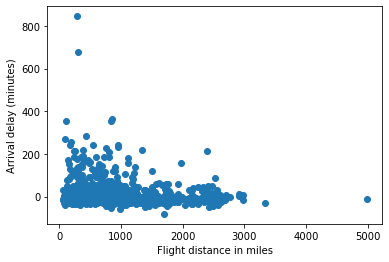

In [41]:
plt.scatter(x,y)
plt.xlabel('Flight distance in miles')
plt.ylabel('Arrival delay (minutes)')

In [42]:
df['mkt_carrier'].unique()

array(['B6', 'UA', 'AA', 'DL', 'WN', 'F9', 'HA', 'AS', 'NK', 'G4', 'VX'],
      dtype=object)

<AxesSubplot:xlabel='mkt_carrier', ylabel='arr_delay'>

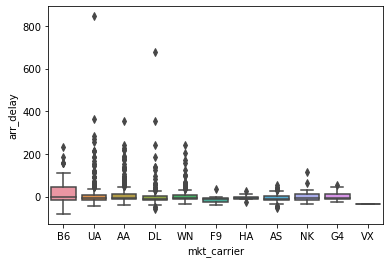

In [69]:
sns.boxplot(x='mkt_carrier', y="arr_delay", data=df)

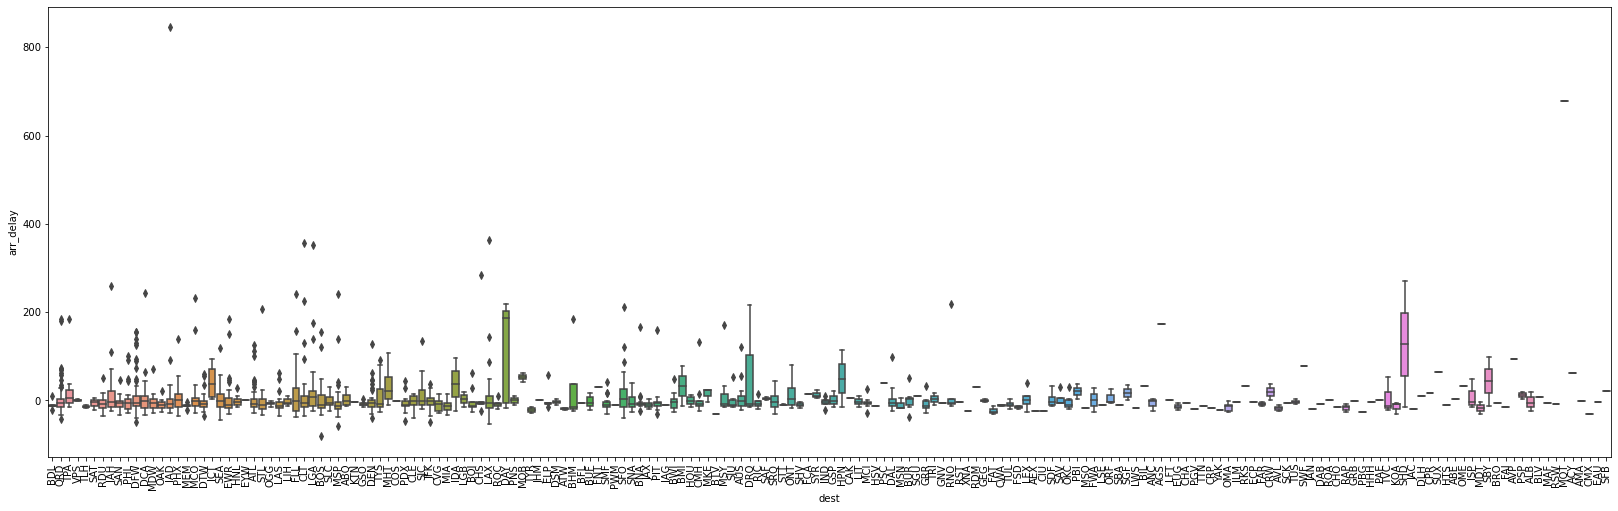

In [83]:
a4_dims = (28, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.boxplot(x='dest', y="arr_delay", data=df, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [85]:
df[['dep_time','crs_dep_time']]

,dep_time,crs_dep_time
0,1237.0,1234
1,718.0,730
2,1120.0,1125
3,1212.0,1215
4,1222.0,1220
...,...,...
1476,1827.0,1740
1477,2128.0,2132
1478,1848.0,1857
1479,1739.0,1709


In [149]:
X = df[['mkt_carrier','distance','origin','dest','crs_dep_time']]
y = df[['arr_delay']]

In [150]:
X

,mkt_carrier,distance,origin,dest,crs_dep_time
0,B6,1666.0,SJU,BDL,1234
1,UA,763.0,BTV,ORD,730
2,UA,264.0,CVG,ORD,1125
3,AA,1012.0,ORD,TPA,1215
4,AA,641.0,DFW,VPS,1220
...,...,...,...,...,...
1476,WN,404.0,SNA,SMF,1740
1477,DL,743.0,ATL,DSM,2132
1478,AS,2496.0,BOS,SEA,1857
1479,G4,1144.0,PSM,SFB,1709


In [ ]:
# mkt_carrier
# origin
# dest
# dest_city_name
# distance
# flights
# carrier_delay
# weather_delay
# air_time
# fl_date

In [151]:
from sklearn.model_selection import train_test_split

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [140]:
# Finds correct index for WWO json for the right 3 hour period, in order to find weather description

# parameters(time (h,m))   returns (index(int))
def decide_time(time):
    if time[:-2] == '':
        h = 0
    else:
        h = int(time[:-2])
    # try:
    m = int(time[-2:])
    # except:
    #     print("ERROR: m is", time[-2:], '!!!')
        
    if m > 30 & h != 23:  # averages the hour up using minutes, unless it rolls over to next day (past 2400)
        h+1
    if h >= 21:
        return 7
    elif h >= 18:
        return 6
    elif h >= 15:
        return 5
    elif h >= 12:
        return 4
    elif h >= 9:
        return 3
    elif h >= 6:
        return 2
    elif h >= 3:
        return 1
    else:
        return 0   # Probably the worst function I've ever wrote, don't know python well enough to make this concise (enumerate instead?)

In [141]:
airports = pd.read_csv('airports.csv')  # found a database of airports, so with airport IATA code i can get the lat,lon coords for the actual weather around that airport
                                        # not just the whole city. Link to the database: https://davidmegginson.github.io/ourairports-data/airports.csv
def get_latlon(row):                     
    
    IATA = row['origin']          
    latlon = airports[airports['iata_code']==IATA][['latitude_deg','longitude_deg']].values[0]

    return latlon

In [142]:
def get_weatherDesc(row):
    date, time = row['fl_date'], str(row['crs_dep_time'])
    lat,lon = get_latlon(row)
    time_cursor = decide_time(time)
    
    url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={API_key}&q={lat},{lon}&date={date}&num_of_days=1&format=json"
    data = requests.get(url).json()

    weather = data['data']['weather'][0]['hourly'][time_cursor]['weatherDesc'][0]['value']
    return weather 

In [148]:
df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,1666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,1012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,404.0,8.0,0.0,0.0,0.0,34.0,NaN,NaN,NaN,NaN
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,2496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,1144.0,0.0,0.0,0.0,0.0,21.0,NaN,NaN,NaN,NaN


In [113]:
df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,AS,B6,DL,F9,G4,HA,NK,UA,VX,WN
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,0,1,0,0,0,0,0,0,0,0
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,0,0,0,0,0,0,0,1,0,0
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,0,0,0,0,0,0,0,1,0,0
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,0,0,0,0,0,0,0,0,0,0
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,0,0,0,0,0,0,0,0,0,1
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,0,0,1,0,0,0,0,0,0,0
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,1,0,0,0,0,0,0,0,0,0
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#### WHATEVER YOU DO DON"T TOUCH THIS WE REALLY NEED THOSE API CALLS

for index, row in df.iterrows():
        print('.', end='')
        df.loc[index, 'dep_weather'] = get_weatherDesc(row)

.

KeyError: 'weather'

In [147]:
#### TEST THAT THE JSON IS CORRECTLY PARSED     DON"T TOUCH LOL WE NEED THOSE API CALLS

IATA = 'SJU'

date = '2019-05-15'
lat,lon = latlon = airports[airports['iata_code']==IATA][['latitude_deg','longitude_deg']].values[0]


url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={API_key}&q={lat},{lon}&date={date}&num_of_days=1&format=json"
data = requests.get(url).json()
data

{'data': {'error': [{'msg': 'API key has reached calls per day allowed limit.'}]}}